# Experiment B: Symmetry Removal Algorithm, Interpretability

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg


import os
import jax.numpy as jnp
import numpy as np
from sklearn.cluster import KMeans

import global_settings
import visualization
from utils import experiments, results, evaluation, equioutput, graphs
from data import standardize

In [ ]:
experiment = experiments.ExperimentSampleStandard(
    settings=experiments.settings.SettingsExperimentSample(
        output_path=global_settings.PATH_RESULTS,
        dataset=global_settings.DATASET_NAMES[1],
        dataset_normalization="standardization",
        hidden_layers=1,
        hidden_neurons=3,
        activation="tanh",
        activation_last_layer="none",
        num_warmup=2**10,
        statistic="reduced",
        statistic_p=0.99,
        samples_per_chain=1,
        identifiable_modes=3,
        pool_size=1, # has no effect in jupyter notebook, use script instead
        seed=0,
        overwrite_chains=None
    )
)

## Run experiment

In [ ]:
experiment.run()

## Optional: Save Experiment

## Optional: Load experiment

In [2]:
result = results.ResultSample.load_from_file(os.path.join(global_settings.PATH_RESULTS, "{}.tar.gz".format(
    "e851ba9827843f1e59e7369eb2bf4c91" # here the result identifier
)))
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
experiment.set_result(result)

## Remove Symmetries

In [3]:
sequential_helper = equioutput.SequentialHelper(
    transformation=experiment._model_transformation,
    dataset=experiment._dataset
)
structured_sequential_samples_parameters = sequential_helper.structured_sequential_samples_parameters(
    samples_parameters=experiment.result.samples["parameters"]
)
symmetry_helper = equioutput.SymmetryHelper(structured_sequential_samples_parameters)

### Before Removal

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


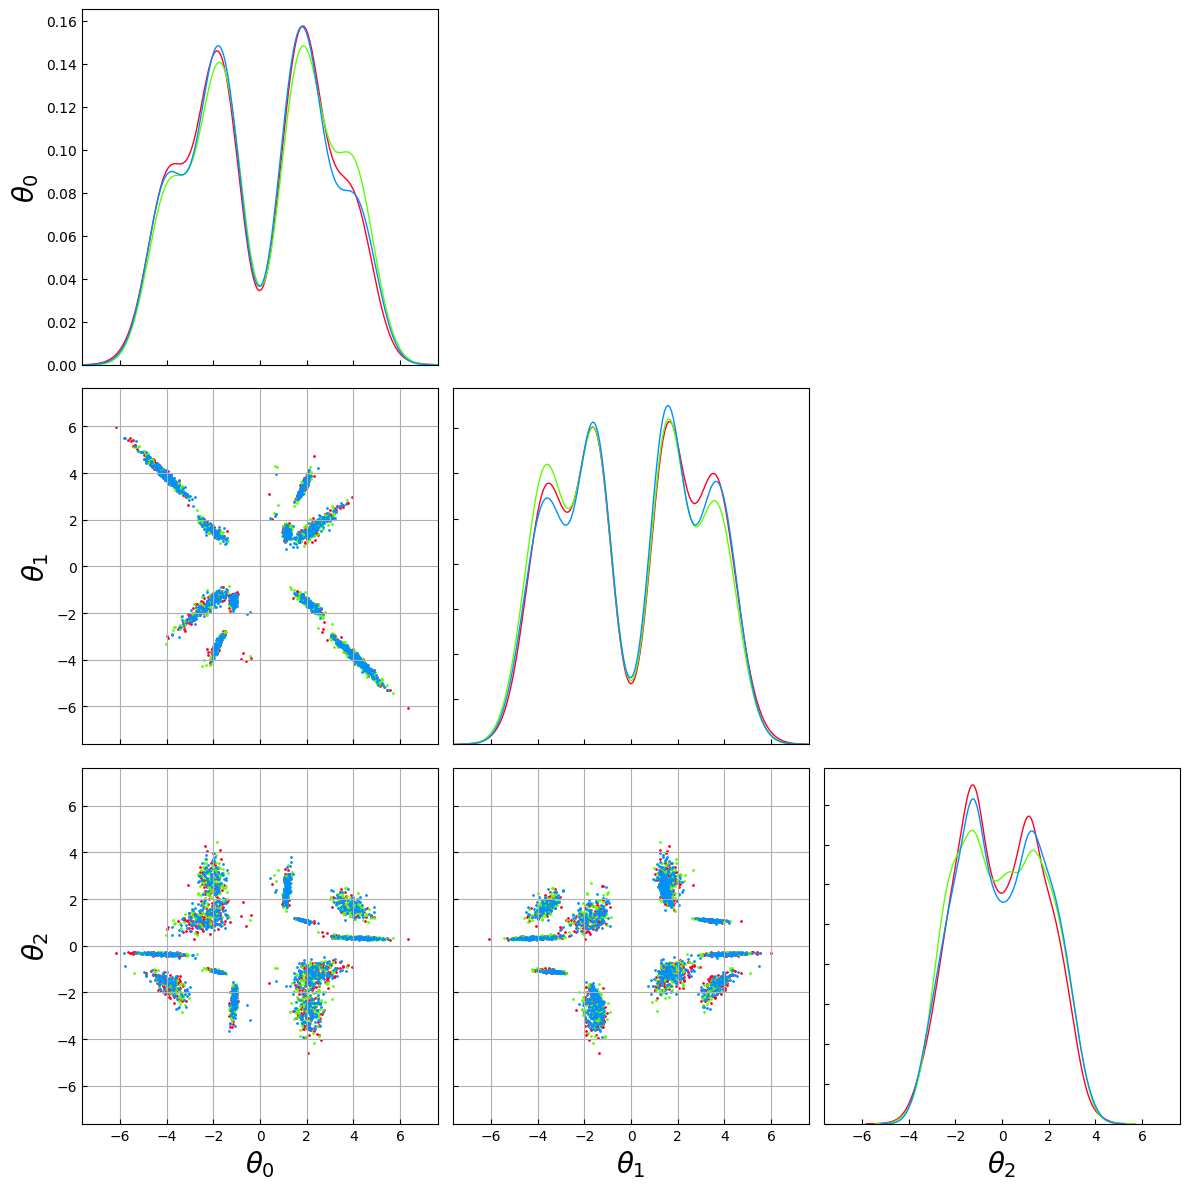

In [4]:
subspace_0 = symmetry_helper.hidden_layer_subspace(layer=0)
data_list = list(subspace_0.transpose(1, 0, 2))

figure = visualization.TriangleFigure(
    settings=visualization.settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=visualization.settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=data_list
)

In [5]:
symmetry_helper.remove_symmetries(similarity_matrix="rbf", iterations=256, tanh_planes=2, k=1024, verbose=True)

epoch: 0,  loss: 1.8516122102737427, normal l2 norm: 0.8400658369064331
epoch: 8,  loss: 0.3924945592880249, normal l2 norm: 0.7837432622909546
epoch: 16,  loss: 0.32107681035995483, normal l2 norm: 0.74131178855896
epoch: 24,  loss: 0.3161930739879608, normal l2 norm: 0.74226313829422
epoch: 0,  loss: 1.5113452672958374, normal l2 norm: 2.373389482498169
epoch: 8,  loss: 0.3943684697151184, normal l2 norm: 0.7797302603721619
epoch: 16,  loss: 0.3514822721481323, normal l2 norm: 0.7687110304832458
epoch: 24,  loss: 0.3474629521369934, normal l2 norm: 0.7529984712600708


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [00:12<00:00, 301.84it/s]


0 2536
1 1532
2 767
3 396
4 184
5 102
6 56
7 35
8 20
9 7
10 5
11 3
12 0
13 0
14 0
15 0
16 0
17 0
18 0


### After Removal

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.30it/s]


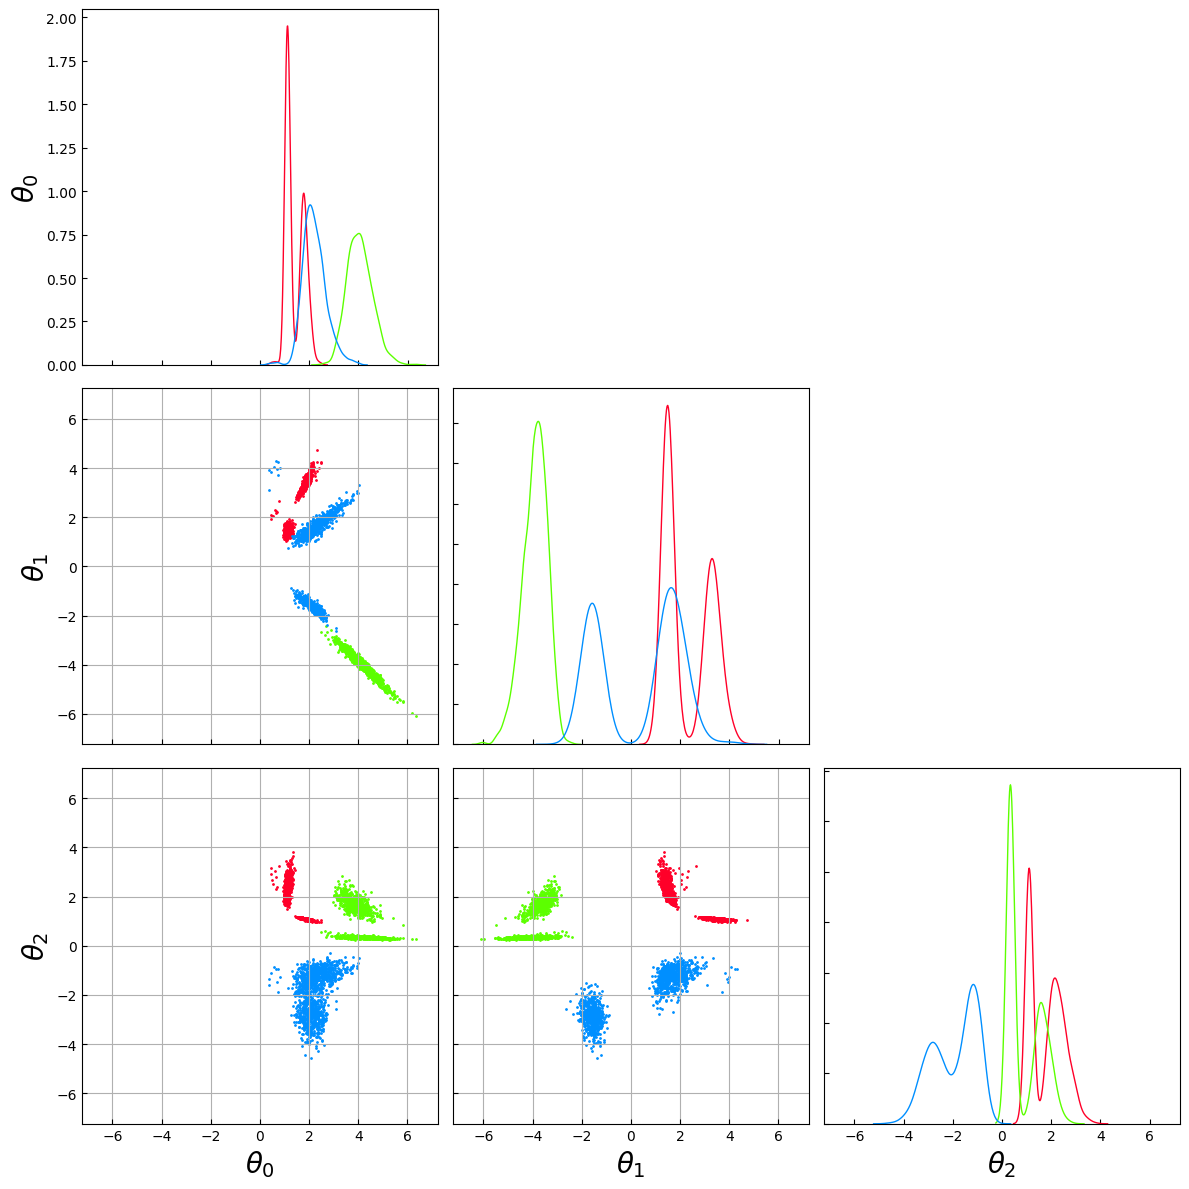

In [6]:
subspace_0 = symmetry_helper.hidden_layer_subspace(layer=0)
data_list = list(subspace_0.transpose(1, 0, 2))

figure = visualization.TriangleFigure(
    settings=visualization.settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=visualization.settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=data_list
)

## Clustering

In [ ]:
samples_posthoc = standardize(structured_sequential_samples_parameters.samples_parameters)
lambdas_posthoc, eigenvectors = graphs.get_knn_sc_eigenvalues(samples_posthoc)

# KMeans
k = 3
init_means = eigenvectors[:k, :k]
labels = KMeans(n_clusters=k, init=init_means, max_iter=1000, tol=1e-6).fit(jnp.asarray(eigenvectors[:, :k])).labels_

## Visualization of clusters in full parameter space after symmetry removal

cluster shape (536, 10)
cluster shape (8, 10)
cluster shape (730, 10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.80it/s]


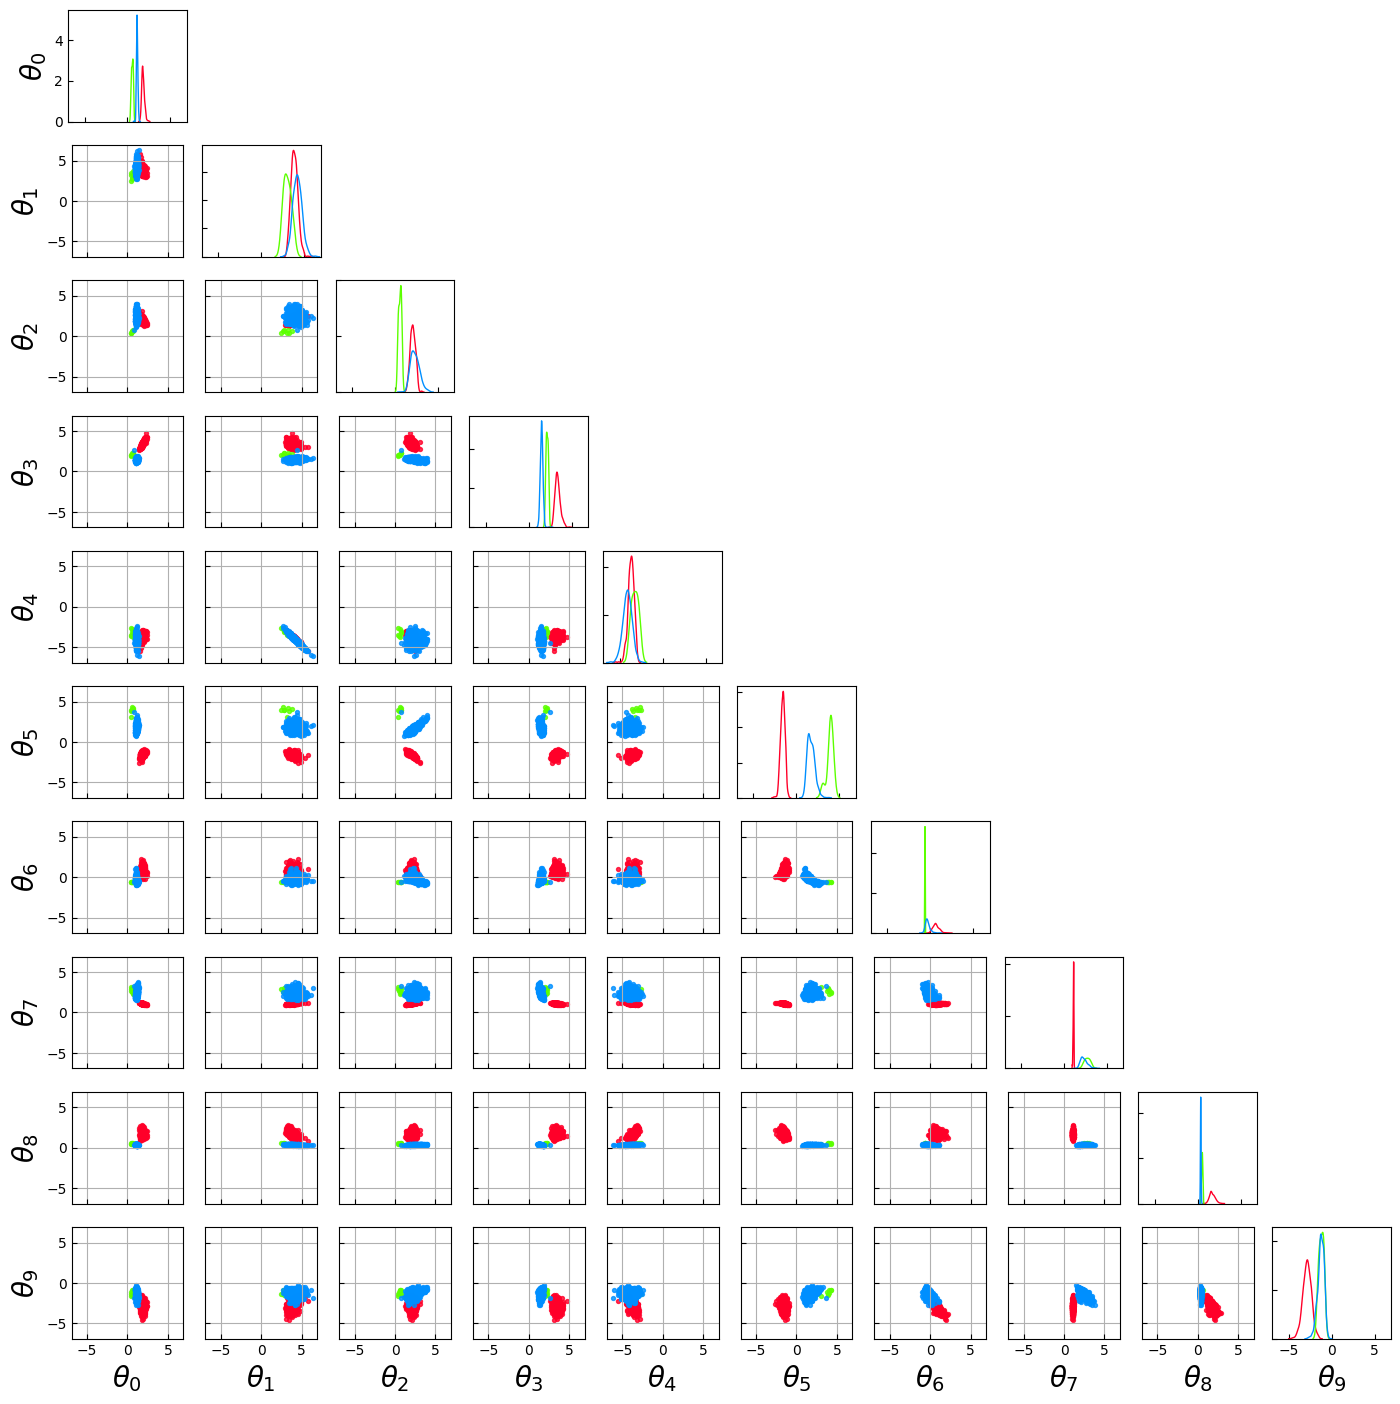

In [9]:
subsets = []
for i in range(k):
    selection = jnp.argwhere(labels == i).squeeze()
    subset = structured_sequential_samples_parameters.samples_parameters[np.array(selection)]
    print("cluster shape", subset.shape)
    subsets.append(subset)

figure = visualization.TriangleFigure(
    settings=visualization.settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=visualization.settings.SettingsScatter(
            alpha=0.8,
            size=8.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=subsets,
    triangle="lower"
)

## Function space

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [00:02<00:00, 280.54it/s]


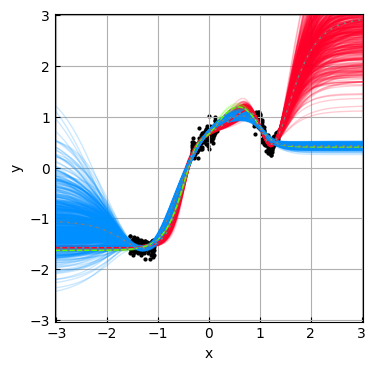

In [15]:
figure = visualization.RegressionFigure(
    settings=visualization.settings.SettingsRegressionFigure(
        settings_plot=visualization.settings.SettingsPlot(
            alpha=0.2,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[subsets[0][:], subsets[1][:], subsets[2][:]],
    std=experiment.result.samples["std"].mean()
)